In [4]:
import random
import copy
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

Upload the Anime images dataset and unzip

In [ ]:
!wget http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
!unzip -qq animeface-character-dataset.zip

--2021-12-25 12:27:09--  http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
Resolving www.nurs.or.jp (www.nurs.or.jp)... 54.187.126.238
Connecting to www.nurs.or.jp (www.nurs.or.jp)|54.187.126.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592335393 (565M) [application/zip]
Saving to: ‘animeface-character-dataset.zip’

animeface-character 100%[===================>] 564.89M  10.3MB/s    in 71s     

2021-12-25 12:28:20 (7.93 MB/s) - ‘animeface-character-dataset.zip’ saved [592335393/592335393]



Split dataset into test, validation and train data set of images, resizing images into 64x64 size

In [ ]:
x_train = []
x_val = []
x_test = []

directories = os.listdir('/home/tsm62803/my_code/animefaces256cleaner')
for directory in directories:
  dir_path = '/home/tsm62803/my_code/animefaces256cleaner'+directory
  num_fil = 0
  num_train = 0
  num_val = 0
  num_test = 0
  if os.path.isdir(dir_path):
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        num_fil += 1
    num_train = int(round(num_fil*0.7))
    num_val = int(round((num_fil-num_train)*0.5))
    num_test = int(round(num_fil-num_train-num_val))
    i = 0
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        filepath = dir_path+"/"+filename
        if i<num_train:
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_train.append(img)
        elif i<(num_train+num_val):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_val.append(img)
        elif i<(num_train+num_val+num_train):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_test.append(img)
        i += 1
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

This is example of images in database

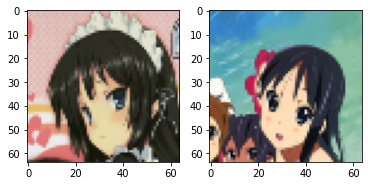

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(x_train[0])
plt.subplot(1, 2, 2)
plt.imshow(x_val[10])
plt.show()

Data normalization to values in range [0-1] and reshape to array suitable for network



In [ ]:
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_val = x_val.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

x_train = np.reshape(x_train, (len(x_train), 64, 64, 3))
x_val = np.reshape(x_val, (len(x_val), 64, 64, 3))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 3))

Applying noise to images



In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

That is how the first 6 noisy data images looks like



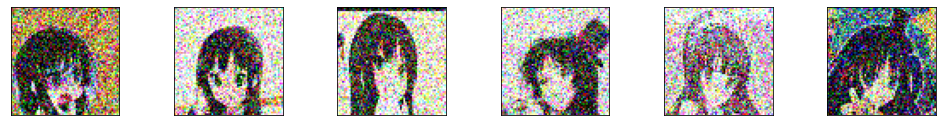

In [ ]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We use similar convolutional autoencoder model as with the MNIST dataset, but now with 3 channels for RGB images



In [ ]:
input_img = Input(shape=(64, 64, 3))  # shape of the images that wil be on input

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Train network for 100 epochs with noisy images as input and correct images as desired output



In [ ]:
log = autoencoder.fit(x_train_noisy, x_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_noisy, x_val),
                verbose=1)

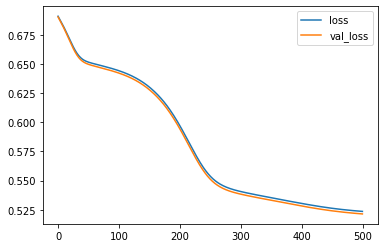

In [ ]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Testing the denoising autoencoder and visualizing input images and output reconstruction of autoencoder



In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 1
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_noisy[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i+n + n)
    plt.imshow(decoded_imgs[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()

NameError: ignored

# Inpainting images - stripes
As before, we test denoising autoencoder for inpainting, so we apply into images randomly stripes




In [ ]:
stripes_no = 24
x_train_inpaint = copy.deepcopy(x_train)
x_val_inpaint = copy.deepcopy(x_val)
x_test_inpaint = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_train_inpaint[i])):
        if j in stripes:
            x_train_inpaint[i][j] = np.zeros((64,1))
            
for i in range(len(x_val_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_val_inpaint[i])):
        if j in stripes:
            x_val_inpaint[i][j] = np.zeros((64,1))

for i in range(len(x_test_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_test_inpaint[i])):
        if j in stripes:
            x_test_inpaint[i][j] = np.zeros((64,1))

Visualizing input images with stripes



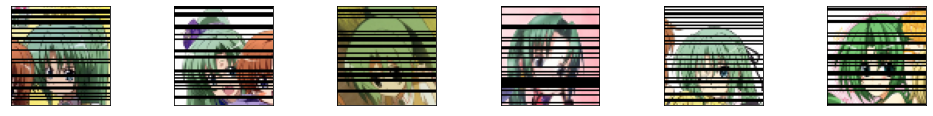

In [ ]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fit into the same network model once again but know the images with stripes



In [ ]:
log = autoencoder.fit(x_train_inpaint, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint, x_val),
                verbose=2)

Learning loss curve



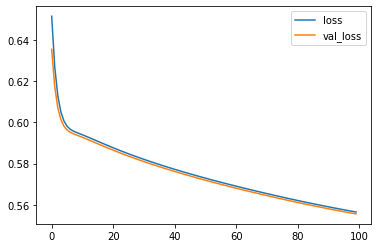

In [ ]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Now tests and visualization of reconstructed images. Displayed in order: original image, image with stripes, reconstructed image



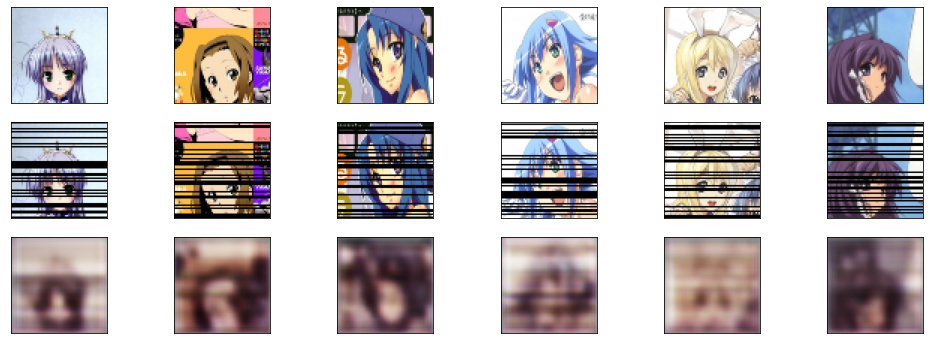

In [ ]:
decoded_imgs_inpaint = autoencoder.predict(x_test_inpaint)
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_inpaint[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i +n+ n)
    plt.imshow(decoded_imgs_inpaint[r].reshape(64, 64, 3))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Inpainting - blocks
Creating data from dataset images with randomly placed gray block of size 24x24

  

In [ ]:
block_size = 24
x_train_inpaint_block = copy.deepcopy(x_train)
x_val_inpaint_block = copy.deepcopy(x_val)
x_test_inpaint_block = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_train_inpaint_block[i][x+j][y+k] = 0.5 # gray color
            
for i in range(len(x_val_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_val_inpaint_block[i][x+j][y+k] = 0.5 

for i in range(len(x_test_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_test_inpaint_block[i][x+j][y+k] = 0.5

Visualizing input images with random gray blocks



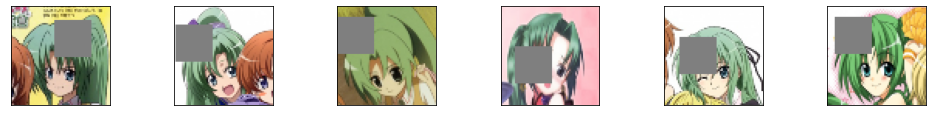

In [ ]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint_block[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fit into the same network model once again but know with the images with grayblocks



In [ ]:
log = autoencoder.fit(x_train_inpaint_block, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint_block, x_val),
               verbose=2)

Learning loss curve



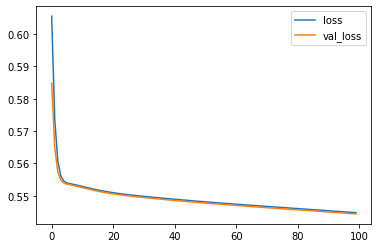

In [ ]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Now tests and visualization of reconstructed images. Displayed in order: original image, image with gray blocks, reconstructed image



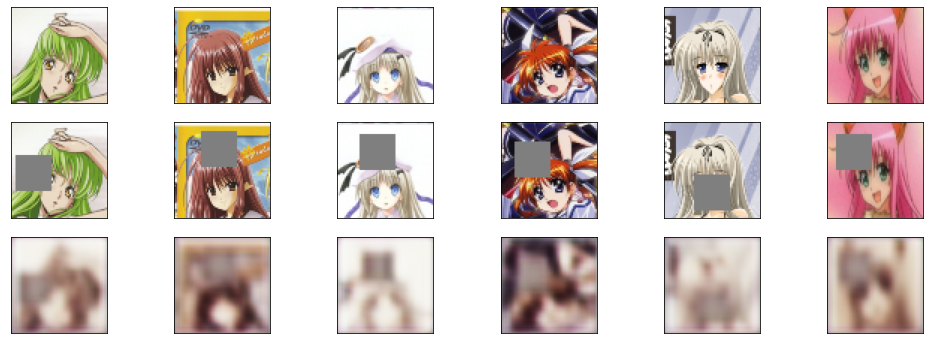

In [ ]:
decoded_imgs_inpaint_block = autoencoder.predict(x_test_inpaint_block)
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_inpaint_block[r].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(decoded_imgs_inpaint_block[r].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()